# Given a list of object ids, extracts their avros to get pixel coordinates of their detections, plot their coordinates, stamps and overplot in aladin

```Authors: Francisco Förster, Last updated: 20251009```

In this notebook we explore a series of supernova candidates that were located around the same galaxy and around the same time, but not exactly in the same position. We will use the ALeRCE client (https://alerce.readthedocs.io/en/latest/index.html, which can be installed with pip).

We found that the x, y position in the CCDs where all very similar, which suggests that in fact these candidates were due to a region of bad pixels in the CCD.

*It is highly recommended that you try this notebook in Google Colab using the following [link](https://colab.research.google.com/github/alercebroker/usecases/blob/master/notebooks/ALeRCE_API_check_pixels.ipynb).*
This will avoid you from having to sort out library installation problems and focus on the contents of the tutorial. You can try installing the dependencies later in your own system.

In [1]:
#!pip install alerce

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import ipyaladin as ipyal # See installation instructions here: https://github.com/cds-astro/ipyaladin
from astropy.table import Table, Column
from astropy import coordinates
import numpy as np

In [3]:
import requests

In [4]:
from alerce.core import Alerce
client = Alerce()

# The list of candidates

In [5]:
oids = ["ZTF19adbtqgy", "ZTF20aacbijc", "ZTF20aaehjjm", "ZTF20aaebiae", "ZTF20aaejaax"]

# Check avro files for pixel position

In [6]:
df = []
for oid in oids:
    
    # Get candid
    candid = client.query_detections(oid=oid, format='pandas').candid.min()
    print(oid, candid)
    
    # Get avro
    url = "https://avro.alerce.online/get_avro_info?oid=" \
          + str(oid) + "&candid=" + str(candid)
    r = requests.request(url=url, method="GET")
    response = r.json() if r.status_code == 200 else {}
    
    # Extract selected fields
    fields = ["jd", "ra", "dec", "xpos", "ypos", "rb", "drb"]
    df.append(pd.DataFrame(data = [[oid, candid] \
                                   + [response['candidate'][field] for field in fields]],
                            columns=["oid", "candid", "jd", "ra", "dec",
                                     "xpos", "ypos", "rb", "drb"]))
df = pd.concat(df)
df.set_index("oid", inplace=True)
df

ZTF19adbtqgy 1092289313615015065
ZTF20aacbijc 1097444403615015104
ZTF20aaehjjm 1100451663615015164
ZTF20aaebiae 1100187173615015124
ZTF20aaejaax 1101179013615015179


,candid,jd,ra,dec,xpos,ypos,rb,drb
oid,,,,,,,,
ZTF19adbtqgy,1092289313615015065,2.458847e+06,132.499845,70.311704,1682.025879,2919.749268,0.365714,0.999991
ZTF20aacbijc,1097444403615015104,2.458852e+06,132.511787,70.313686,1681.534546,2919.635254,0.395714,0.999998
ZTF20aaehjjm,1100451663615015164,2.458855e+06,132.511148,70.312382,1681.734741,2919.563477,0.421429,0.999996
ZTF20aaebiae,1100187173615015124,2.458855e+06,132.515880,70.292508,1681.752686,2919.568359,0.394286,1.000000
ZTF20aaejaax,1101179013615015179,2.458856e+06,132.521993,70.292265,1681.814941,2919.816895,0.641429,1.000000


# Plot the x, y positions

Text(0, 0.5, 'ypos')

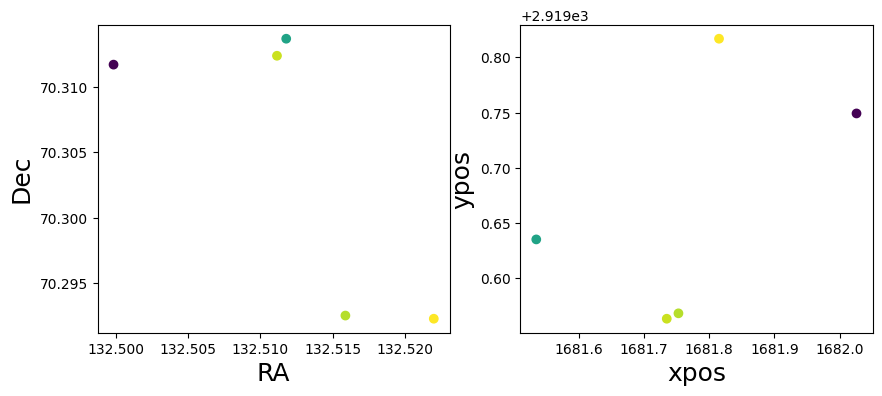

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].scatter(df.ra, df.dec, c = df.jd)
ax[0].set_xlabel("RA", fontsize=18)
ax[0].set_ylabel("Dec", fontsize=18)
ax[1].scatter(df.xpos, df.ypos, c=df.jd)
ax[1].set_xlabel("xpos", fontsize=18)
ax[1].set_ylabel("ypos", fontsize=18)

The positions are all very similar in x,y!

# Show stamps

In [8]:
for oid, row in df.iterrows():
    client.plot_stamps(oid, row.candid)

# Display in Aladin

In [9]:
aladin = ipyal.Aladin(target='%s %s' % (df.iloc[0].ra, df.iloc[0].dec),
                      fov=0.15, survey='P/PanSTARRS/DR1/color-z-zg-g')
aladin

Aladin(init_options=['_fov', '_target', 'background_color', 'coo_frame', 'full_screen', 'grid_color', 'grid_op…

Add all the candidates to Aladin

In [10]:
cand = Table.from_pandas(pd.DataFrame(
                data={"MAIN_ID": df.index.tolist(),
                      "ra": df.ra.to_list(),
                      "dec": df.dec.to_list()}))
aladin.add_table(cand)

Note that you can click in individual candidates to see their object ids.